# DIP Training for Super Resolution

testing the first python implementations

In [1]:
!nvidia-smi

Sat May  1 07:38:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 307...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0    23W /  N/A |    398MiB /  7982MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import copy
%config Completer.use_jedi = False

In [3]:
from skimage.metrics import peak_signal_noise_ratio #import compare_psnr

In [4]:
import sys
sys.path.append("../src")
sys.path.append("../src/model")
sys.path.append("../src/utils")
sys.path.append("../src/training_pipeline")
sys.path.append("../")

In [5]:
from model.skip_net import *
from utils.data_processing import *
from utils.data_plotting import *
from training_pipeline.dip import *

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        #tf.config.experimental.set_virtual_device_configuration(
        #gpus[0],
        #[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2024)])
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Data Processing

## Input image and noisy image

In [7]:
sigma = 25
sigma_ = sigma/255.
img_hr = load_image("../data/original/zebra_GT.png")
img_lr = get_low_resolution_image(img_hr, 4)

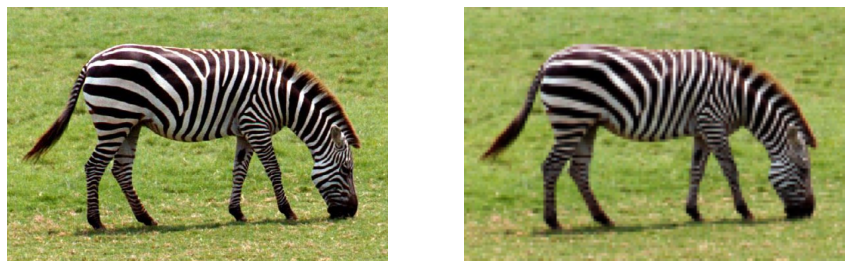

In [8]:
plot_images([img_hr, img_lr])

In [9]:
image_information([img_hr, img_lr])

dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (384, 576, 3) , range: 0.0 - 1.0
dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (96, 144, 3) , range: 0.0 - 1.0


In [10]:
img_cubic, img_nearest = get_baseline_resized_images(img_lr, img_hr.shape)
image_information([img_cubic, img_nearest])

dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (384, 576, 3) , range: 0.0 - 1.0
dtype:  float32 , type:  <class 'numpy.ndarray'>
size:  (384, 576, 3) , range: 0.0 - 1.0


## Network input

In [11]:
net_input = get_network_input((1,384,576,32))
image_information(net_input)

dtype:  <dtype: 'float32'> , type:  <class 'tensorflow.python.framework.ops.EagerTensor'>
size:  (1, 384, 576, 32) , range: 0.0 - 0.09999997913837433


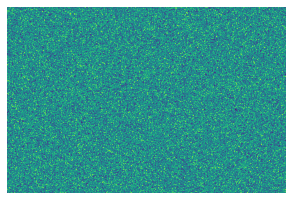

In [12]:
plot_images([net_input[0,:,:,0]],  figsize=(5,5))

# Model

In [13]:
model = skip_net(input_shape=(384,576, 32),nb_filters_down=[128,128,128,128, 128])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(1, 384, 576, 32)]  0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (1, 386, 578, 32)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (1, 192, 288, 128)   36992       reflection_padding2d[0][0]       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (1, 192, 288, 128)   512         conv2d[0][0]                     
______________________________________________________________________________________________

# Training

In [14]:
learning_rate = 0.01
num_iter = 2000
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, 
                                     epsilon=1e-08, amsgrad=False,name='Adam')
mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)

In [15]:
training = DIPTraining(model, mse, adam)

In [16]:
training.set_callbacks(checkpoint='train_run/super_resolution/sr.ckpt')

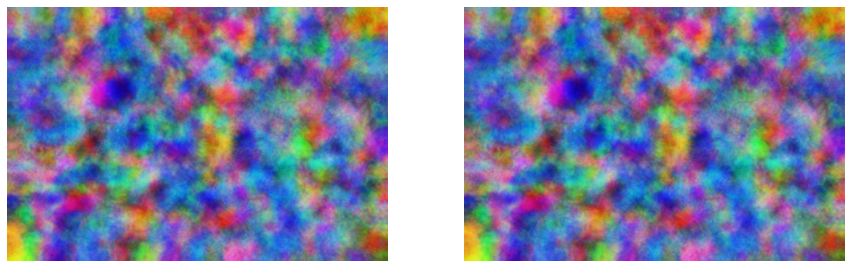

Iteration 00002    Loss 0.125104   PSNR_corrupted: 9.027272   PSRN_gt: 8.760800 PSNR_gt_sm: 9.900707 
Iteration 00002    PSNR_GT improved from 8.760800 to 7.626864. Save model to train_run/super_resolution/sr.ckpt
Iteration 00003    Loss 0.088651   PSNR_corrupted: 10.523178   PSRN_gt: 10.151369 PSNR_gt_sm: 9.960545 
Iteration 00003    PSNR_GT improved from 10.151369 to 8.760800. Save model to train_run/super_resolution/sr.ckpt
Iteration 00004    Loss 0.077167   PSNR_corrupted: 11.125675   PSRN_gt: 10.700431 PSNR_gt_sm: 10.023050 
Iteration 00004    PSNR_GT improved from 10.700431 to 10.151369. Save model to train_run/super_resolution/sr.ckpt
Iteration 00005    Loss 0.063425   PSNR_corrupted: 11.977409   PSRN_gt: 11.466494 PSNR_gt_sm: 10.080620 
Iteration 00005    PSNR_GT improved from 11.466494 to 10.700431. Save model to train_run/super_resolution/sr.ckpt
Iteration 00006    Loss 0.054950   PSNR_corrupted: 12.600301   PSRN_gt: 12.015102 PSNR_gt_sm: 10.133464 
Iteration 00006    PSNR_GT

Iteration 00047    Loss 0.024279   PSNR_corrupted: 16.147762   PSRN_gt: 14.927759 PSNR_gt_sm: 12.032468 
Iteration 00047    PSNR_GT improved from 14.927759 to 14.880886. Save model to train_run/super_resolution/sr.ckpt
Iteration 00048    Loss 0.024158   PSNR_corrupted: 16.169439   PSRN_gt: 14.945854 PSNR_gt_sm: 12.076782 
Iteration 00048    PSNR_GT improved from 14.945854 to 14.927759. Save model to train_run/super_resolution/sr.ckpt
Iteration 00049    Loss 0.023497   PSNR_corrupted: 16.289833   PSRN_gt: 15.038123 PSNR_gt_sm: 12.120691 
Iteration 00049    PSNR_GT improved from 15.038123 to 14.945854. Save model to train_run/super_resolution/sr.ckpt
Iteration 00051    Loss 0.023079   PSNR_corrupted: 16.367894   PSRN_gt: 15.100864 PSNR_gt_sm: 12.208629 
Iteration 00051    PSNR_GT improved from 15.100864 to 14.983583. Save model to train_run/super_resolution/sr.ckpt
Iteration 00052    Loss 0.022601   PSNR_corrupted: 16.458701   PSRN_gt: 15.171105 PSNR_gt_sm: 12.253555 
Iteration 00052    

Iteration 00099    Loss 0.011851   PSNR_corrupted: 19.262401   PSRN_gt: 17.242121 PSNR_gt_sm: 14.313301 
Iteration 00099    PSNR_GT improved from 17.242121 to 17.189415. Save model to train_run/super_resolution/sr.ckpt


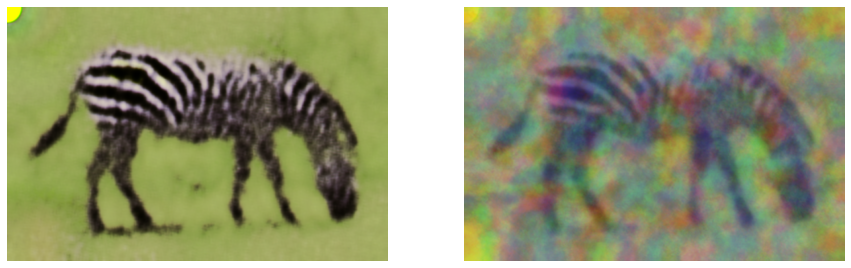


Iteration 00100    PSNR_GT improved from 17.285764 to 17.242121. Save model to train_run/super_resolution/sr.ckpt
Iteration 00102    Loss 0.011289   PSNR_corrupted: 19.473257   PSRN_gt: 17.400016 PSNR_gt_sm: 14.443593 
Iteration 00102    PSNR_GT improved from 17.400016 to 17.260017. Save model to train_run/super_resolution/sr.ckpt
Iteration 00104    Loss 0.011440   PSNR_corrupted: 19.415605   PSRN_gt: 17.375004 PSNR_gt_sm: 14.530590 
Iteration 00104    PSNR_GT improved from 17.375004 to 17.369546. Save model to train_run/super_resolution/sr.ckpt
Iteration 00105    Loss 0.011065   PSNR_corrupted: 19.560389   PSRN_gt: 17.464145 PSNR_gt_sm: 14.575202 
Iteration 00105    PSNR_GT improved from 17.464145 to 17.375004. Save model to train_run/super_resolution/sr.ckpt
Iteration 00107    Loss 0.011054   PSNR_corrupted: 19.564639   PSRN_gt: 17.494437 PSNR_gt_sm: 14.660472 
Iteration 00107    PSNR_GT improved from 17.494437 to 17.393997. Save model to train_run/super_resolution/sr.ckpt
Iteration

Iteration 00158    Loss 0.006895   PSNR_corrupted: 21.614679   PSRN_gt: 18.909943 PSNR_gt_sm: 16.716807 
Iteration 00158    PSNR_GT improved from 18.909943 to 18.865568. Save model to train_run/super_resolution/sr.ckpt
Iteration 00160    Loss 0.006924   PSNR_corrupted: 21.596240   PSRN_gt: 18.888952 PSNR_gt_sm: 16.785337 
Iteration 00160    PSNR_GT improved from 18.888952 to 18.858473. Save model to train_run/super_resolution/sr.ckpt
Iteration 00161    Loss 0.006670   PSNR_corrupted: 21.758603   PSRN_gt: 19.009065 PSNR_gt_sm: 16.820463 
Iteration 00161    PSNR_GT improved from 19.009065 to 18.888952. Save model to train_run/super_resolution/sr.ckpt
Iteration 00163    Loss 0.006651   PSNR_corrupted: 21.771200   PSRN_gt: 19.002568 PSNR_gt_sm: 16.891124 
Iteration 00163    PSNR_GT improved from 19.002568 to 18.959329. Save model to train_run/super_resolution/sr.ckpt
Iteration 00164    Loss 0.006728   PSNR_corrupted: 21.721256   PSRN_gt: 19.004299 PSNR_gt_sm: 16.924498 
Iteration 00164    

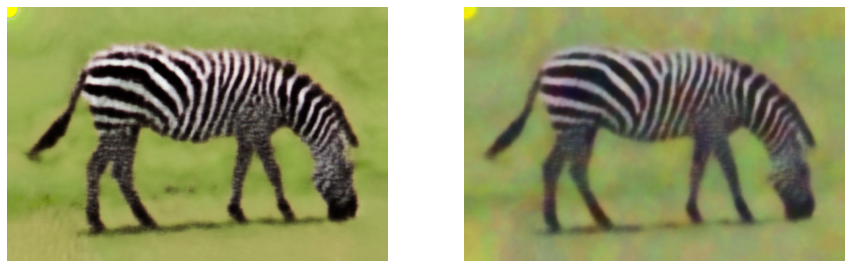

Iteration 00201    Loss 0.005464   PSNR_corrupted: 22.624566   PSRN_gt: 19.527615 PSNR_gt_sm: 18.061101 
Iteration 00201    PSNR_GT improved from 19.527615 to 19.511387. Save model to train_run/super_resolution/sr.ckpt
Iteration 00202    Loss 0.005419   PSNR_corrupted: 22.660451   PSRN_gt: 19.542129 PSNR_gt_sm: 18.087500 
Iteration 00202    PSNR_GT improved from 19.542129 to 19.527615. Save model to train_run/super_resolution/sr.ckpt
Iteration 00203    Loss 0.005433   PSNR_corrupted: 22.649436   PSRN_gt: 19.566336 PSNR_gt_sm: 18.113793 
Iteration 00203    PSNR_GT improved from 19.566336 to 19.542129. Save model to train_run/super_resolution/sr.ckpt
Iteration 00205    Loss 0.005311   PSNR_corrupted: 22.748036   PSRN_gt: 19.553775 PSNR_gt_sm: 18.165732 
Iteration 00205    PSNR_GT improved from 19.553775 to 19.480469. Save model to train_run/super_resolution/sr.ckpt
Iteration 00207    Loss 0.005339   PSNR_corrupted: 22.725182   PSRN_gt: 19.567406 PSNR_gt_sm: 18.215605 
Iteration 00207    

Iteration 00268    Loss 0.004201   PSNR_corrupted: 23.766401   PSRN_gt: 20.192333 PSNR_gt_sm: 19.478096 
Iteration 00268    PSNR_GT improved from 20.192333 to 20.189984. Save model to train_run/super_resolution/sr.ckpt
Iteration 00270    Loss 0.004192   PSNR_corrupted: 23.775649   PSRN_gt: 20.189941 PSNR_gt_sm: 19.509980 
Iteration 00270    PSNR_GT improved from 20.189941 to 20.189801. Save model to train_run/super_resolution/sr.ckpt
Iteration 00271    Loss 0.004102   PSNR_corrupted: 23.869639   PSRN_gt: 20.223581 PSNR_gt_sm: 19.525550 
Iteration 00271    PSNR_GT improved from 20.223581 to 20.189941. Save model to train_run/super_resolution/sr.ckpt
Iteration 00275    Loss 0.004169   PSNR_corrupted: 23.799779   PSRN_gt: 20.254343 PSNR_gt_sm: 19.589383 
Iteration 00275    PSNR_GT improved from 20.254343 to 20.088780. Save model to train_run/super_resolution/sr.ckpt
Iteration 00278    Loss 0.004084   PSNR_corrupted: 23.888642   PSRN_gt: 20.234399 PSNR_gt_sm: 19.633280 
Iteration 00278    

In [17]:
training.train_super_resolution(net_input, img_lr, img_hr, num_iter=300)

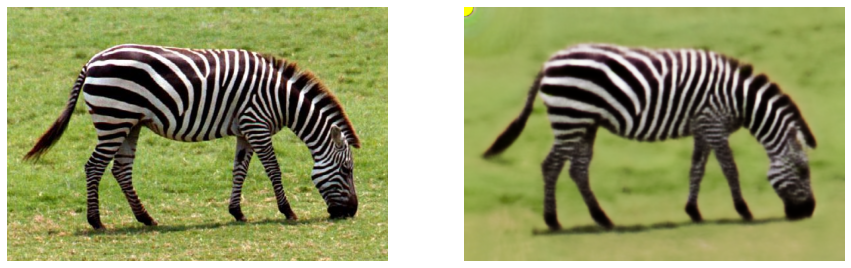

PSNR:  21.155616248975086


In [18]:
out_np = training._model(net_input).numpy()[0]
plot_images([img_hr, out_np])
print("PSNR: ", peak_signal_noise_ratio(img_hr, out_np))

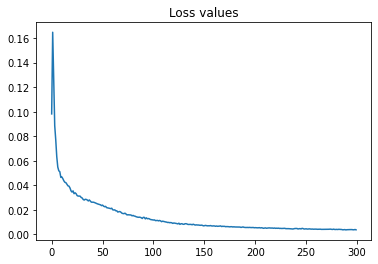

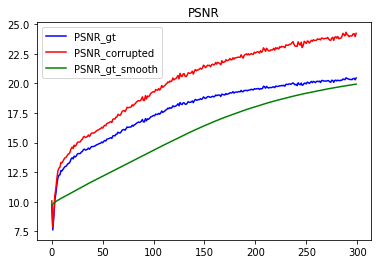

In [19]:
training.plot_history()

# Reinit model

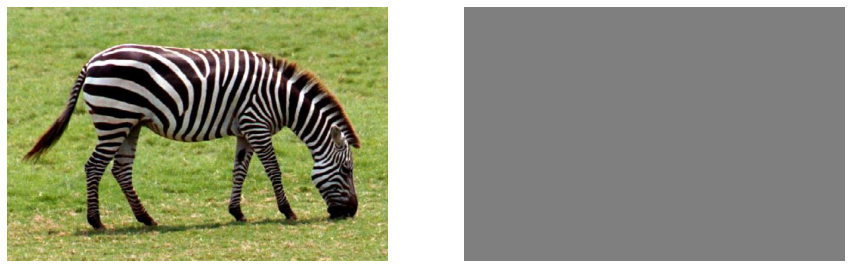

PSNR:  12.264593094627095


In [20]:
# reinit model
model = skip_net(input_shape=(384,576, 32),nb_filters_down=[128,128,128,128, 128])
out_np = model(net_input).numpy()[0]
plot_images([img_hr, out_np])
print("PSNR: ", peak_signal_noise_ratio(img_hr, out_np))

In [21]:
# load weights
model.load_weights('train_run/super_resolution/sr.ckpt')

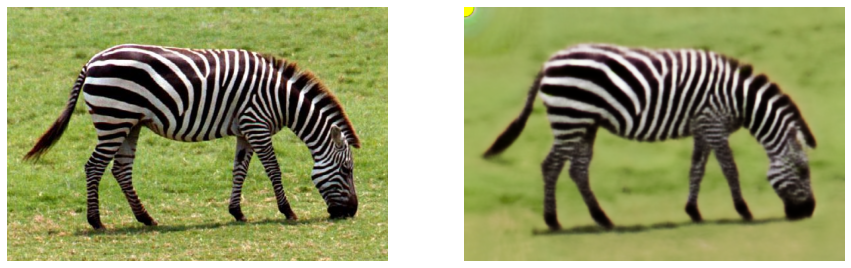

PSNR:  21.15716906170605


In [22]:
# inference of model
out_np = model(net_input).numpy()[0]
plot_images([img_hr, out_np])
print("PSNR: ", peak_signal_noise_ratio(img_hr, out_np))

# Plot outputs

Images


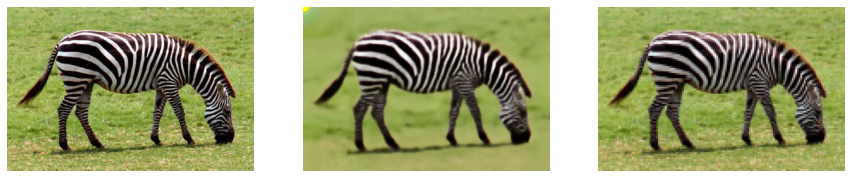

Images with cut outs


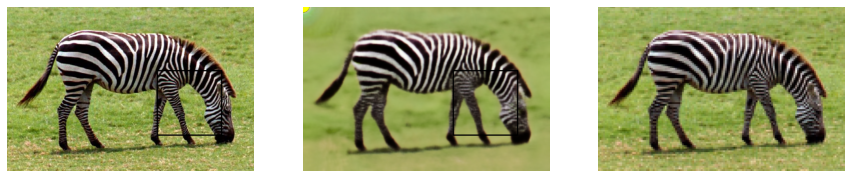

Cut outs


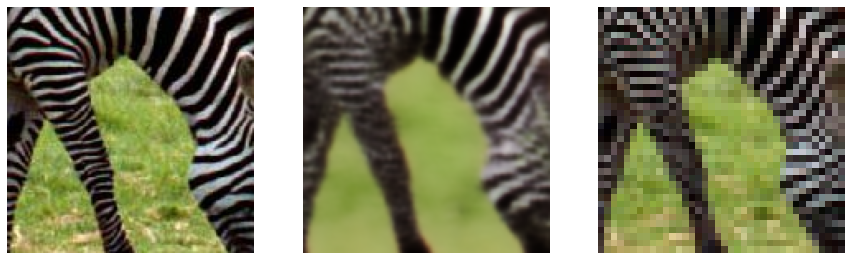

In [23]:
plot_cut_outs_different_sizes([img_hr, out_np], [img_lr], [350,150,500,300])

Images


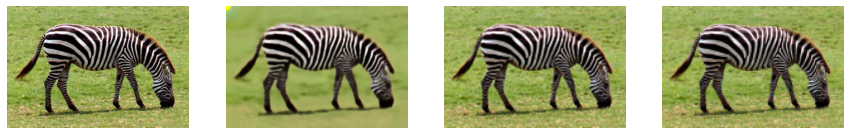

Images with cut outs


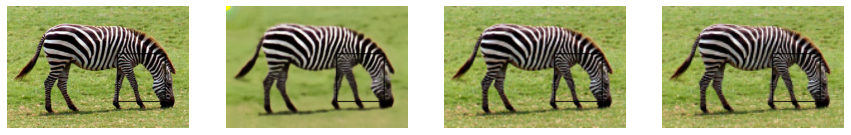

Cut outs


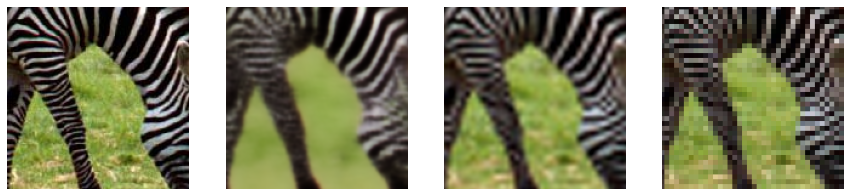

In [24]:
plot_cut_outs([img_hr, out_np, img_cubic, img_nearest], [350,150,500,300])